# Assignment 7 
Halka Hanna


In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Helper function

In [113]:
def build_model(train, val, holiday=False, season=False, s_name=None, p=1, calculate_metrics=True, pred_len=None, freq=None):
    model = Prophet()
    if holiday == True:
        model.add_country_holidays(country_name='US')
    if season == True:
        model.add_seasonality(name=s_name, period=p, fourier_order=20)


    if calculate_metrics == False:
        df = pd.concat([train, val], axis=0)
        model.fit(df)
        future_year = model.make_future_dataframe(periods=pred_len, freq=freq)
        forecast = model.predict(future_year)
        return model, forecast
    else:
        model.fit(train)
        future_test = val[['ds']].copy()
        forecast_test = model.predict(future_test)

        y_true = val['y'].values
        y_pred = forecast_test['yhat'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        print(f" MAE = {mae:.2f},\n RMSE = { rmse:.2f}")
        return forecast_test['yhat']


In [94]:
def pred_plot(ds, y_true, y_pred, title=None):
    plt.figure(figsize=(15, 6))
    plt.plot(ds, y_true, label='True values', color='black', alpha=0.6)
    plt.plot(ds, y_pred, label='Pred values', color='red', alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()

In [132]:
def final_model(m, forecast_year, ylabel, title=None) # , year='1990-12-31'):
    # year = pd.to_datetime(year)
    plt.figure(figsize=(15, 7))
    m.plot(forecast_year, ax=plt.gca())
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.title(title)
    m.plot_components(forecast_year)
    # ax.axvline(year, color='red', ls='--')
    plt.show()

---
## Daily Temperature

In [96]:
tempt = pd.read_csv('../data/daily_tempt.csv')
tempt['data_ind'] = tempt['Date']
tempt = tempt.set_index('data_ind')
tempt.index = pd.to_datetime(tempt.index)

train_df = tempt.loc[tempt.index < '1988-01-01']
val_df = tempt.loc[tempt.index >= '1988-01-01']

train = train_df[['mean-tempt']].reset_index()
train['unique_id'] = 'tempt'
train.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
train_tempt = train[['unique_id', 'ds', 'y']]

val = val_df[['mean-tempt']].reset_index()
val['unique_id'] = 'tempt'
val.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
val_tempt = val[['unique_id', 'ds', 'y']]

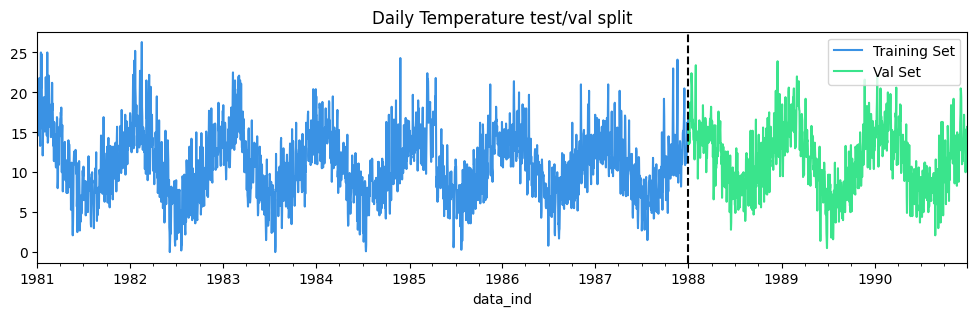

In [97]:
y_train = train_df['mean-tempt']
y_val = val_df['mean-tempt']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Daily Temperature test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('1988-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

23:26:51 - cmdstanpy - INFO - Chain [1] start processing
23:26:51 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.10,
 RMSE = 2.69


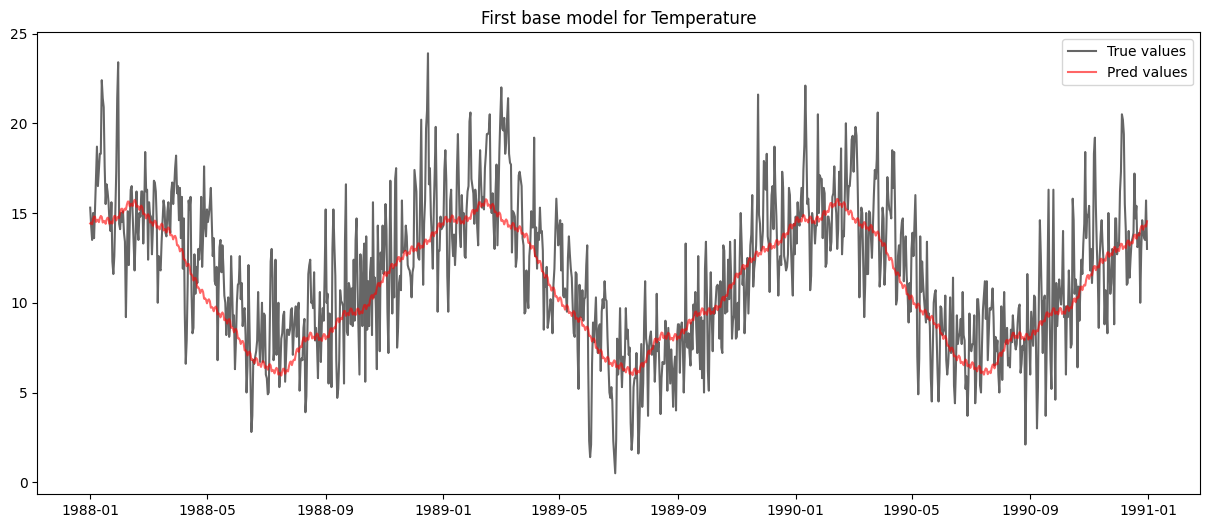

In [98]:
pred = build_model(train_tempt, val_tempt)
pred_plot(val_tempt['ds'], val_tempt['y'], pred, title="First base model for Temperature")

23:26:51 - cmdstanpy - INFO - Chain [1] start processing
23:26:51 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.13,
 RMSE = 2.72


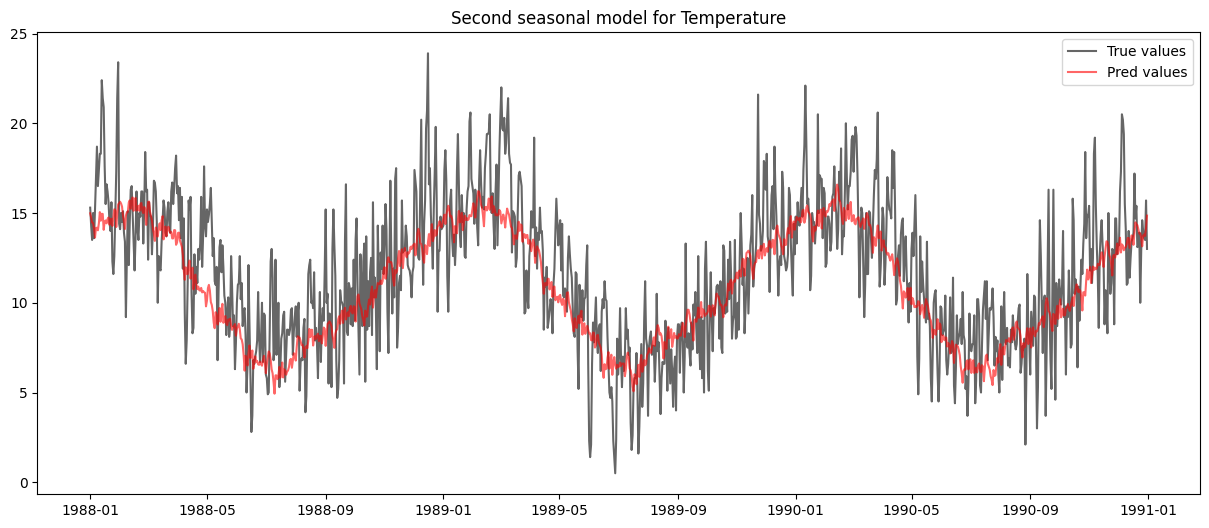

In [99]:
pred = build_model(train_tempt, val_tempt, season=True, s_name='daily', p=31)
pred_plot(val_tempt['ds'], val_tempt['y'], pred, title="Second seasonal model for Temperature")

First model better

23:42:52 - cmdstanpy - INFO - Chain [1] start processing
23:42:52 - cmdstanpy - INFO - Chain [1] done processing


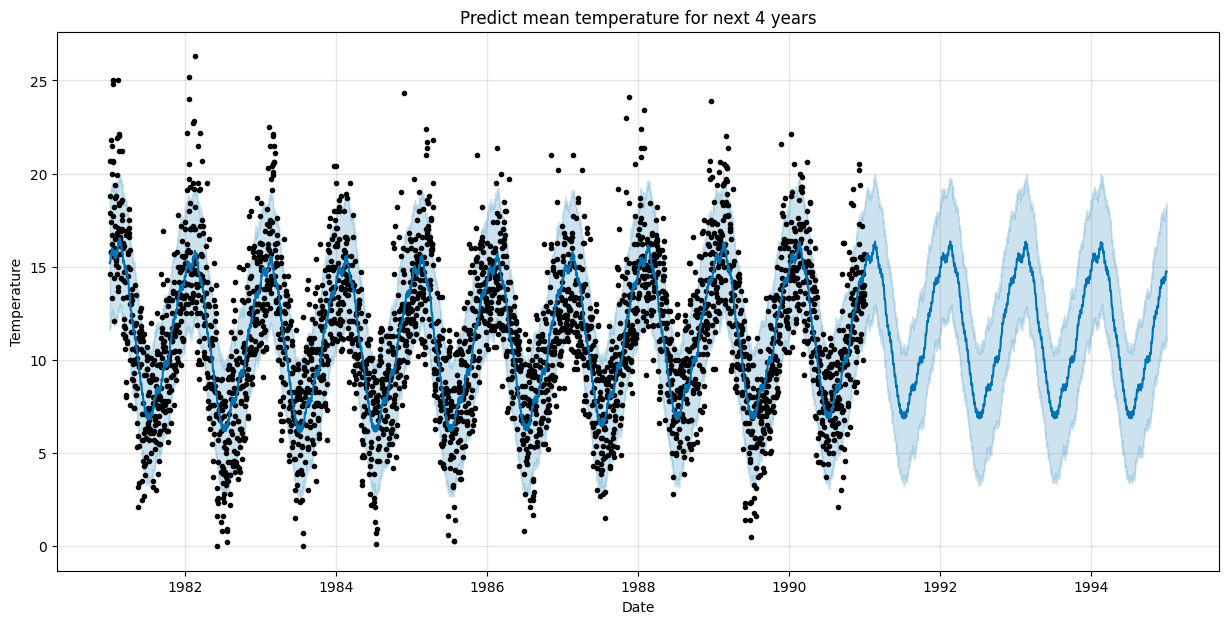

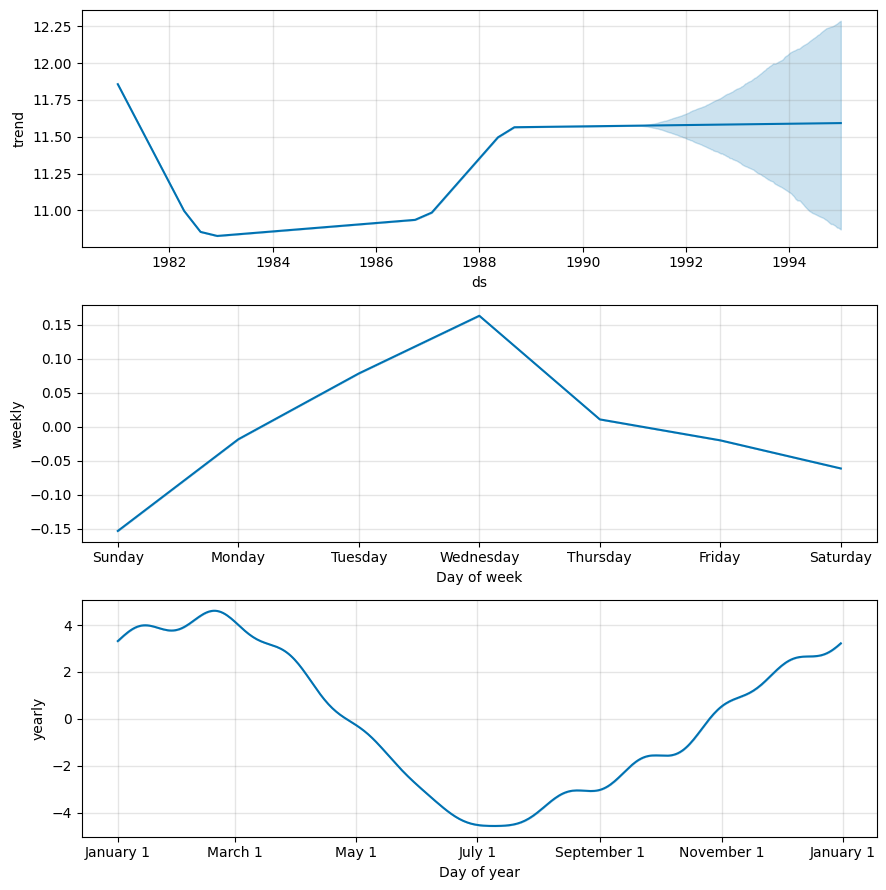

In [133]:
model, pred = build_model(train_tempt, val_tempt, calculate_metrics=False, pred_len=1461, freq='D')
final_model(model, pred, 'Temperature', title="Predict mean temperature for next 4 years")

---
## Weekly CO2


In [101]:
co2 = pd.read_csv('../data/weekly_co2.csv')
co2 = co2[['Date', 'average']]
co2['data_ind'] = co2['Date']
co2 = co2.set_index('data_ind')
co2.index = pd.to_datetime(co2.index)

train_df = co2.loc[co2.index < '2015-07-05']
val_df = co2.loc[co2.index >= '2015-07-05']

train = train_df[['average']].reset_index()
train['unique_id'] = 'co2'
train.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
train_co2 = train[['unique_id', 'ds', 'y']]

val = val_df[['average']].reset_index()
val['unique_id'] = 'co2'
val.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
val_co2 = val[['unique_id', 'ds', 'y']]

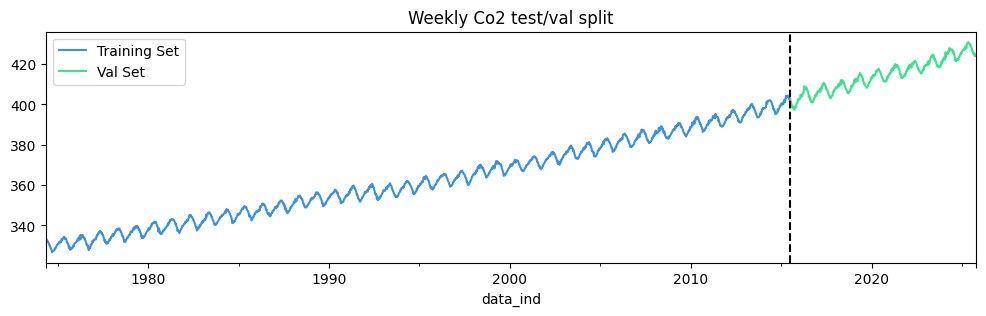

In [102]:
y_train = train_df['average']
y_val = val_df['average']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Weekly Co2 test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('2015-07-05', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

23:26:52 - cmdstanpy - INFO - Chain [1] start processing
23:26:52 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.67,
 RMSE = 2.97


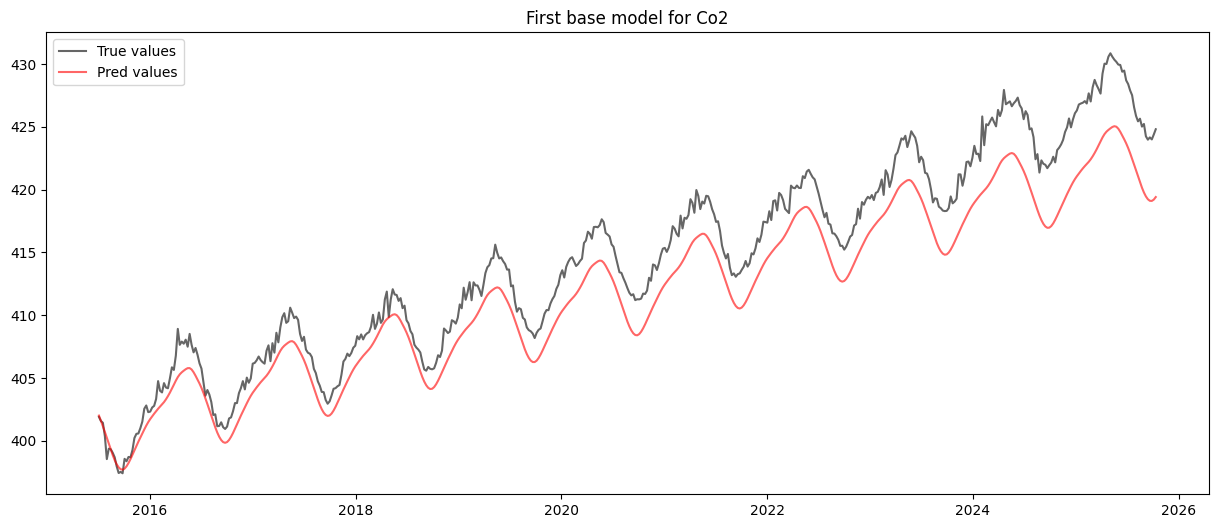

In [103]:
pred = build_model(train_co2, val_co2)
pred_plot(val_co2['ds'], val_co2['y'], pred, title="First base model for Co2")

23:26:53 - cmdstanpy - INFO - Chain [1] start processing
23:26:53 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.67,
 RMSE = 2.98


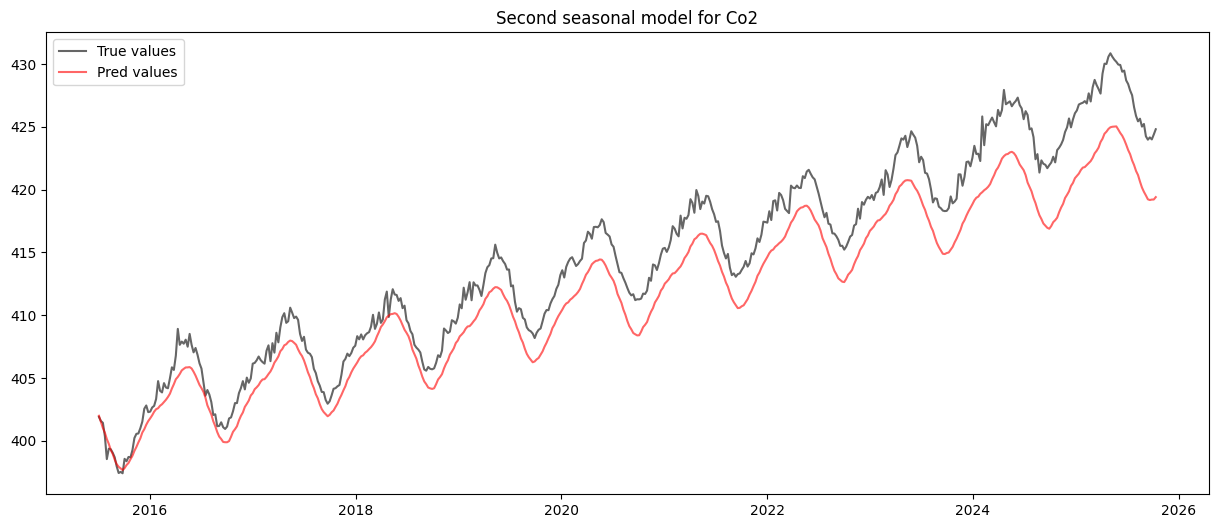

In [104]:
pred = build_model(train_co2, val_co2, season=True, s_name='weakly', p=104)
pred_plot(val_co2['ds'], val_co2['y'], pred, title="Second seasonal model for Co2")

Almost the same but first a little bit better.

23:35:39 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing


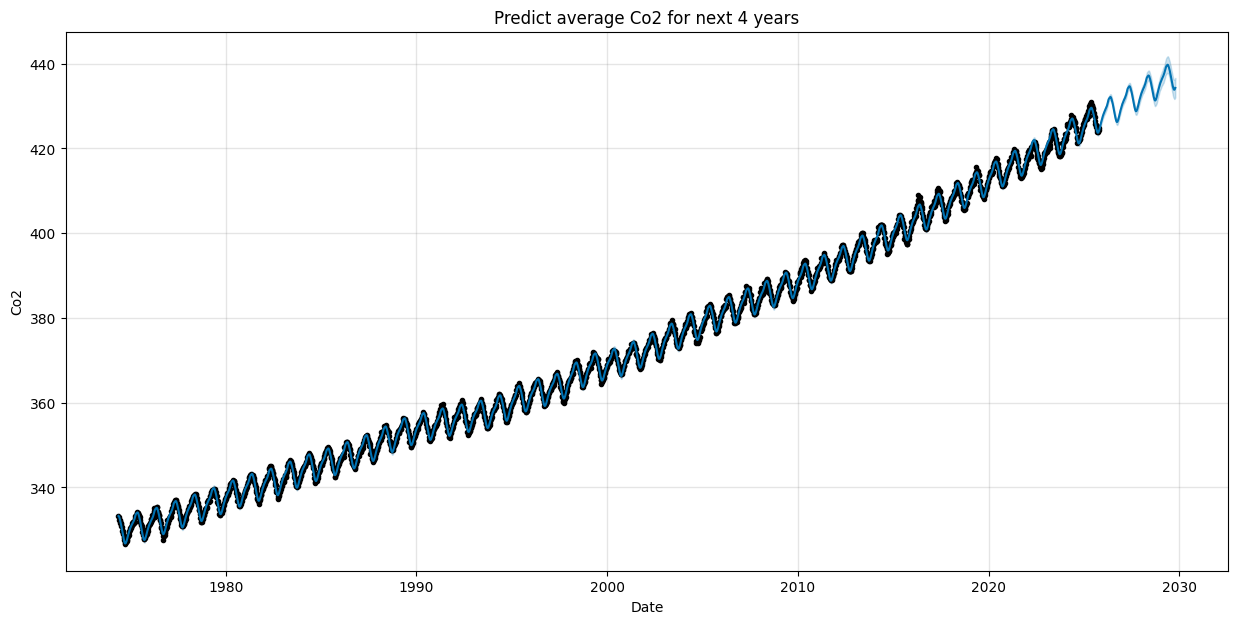

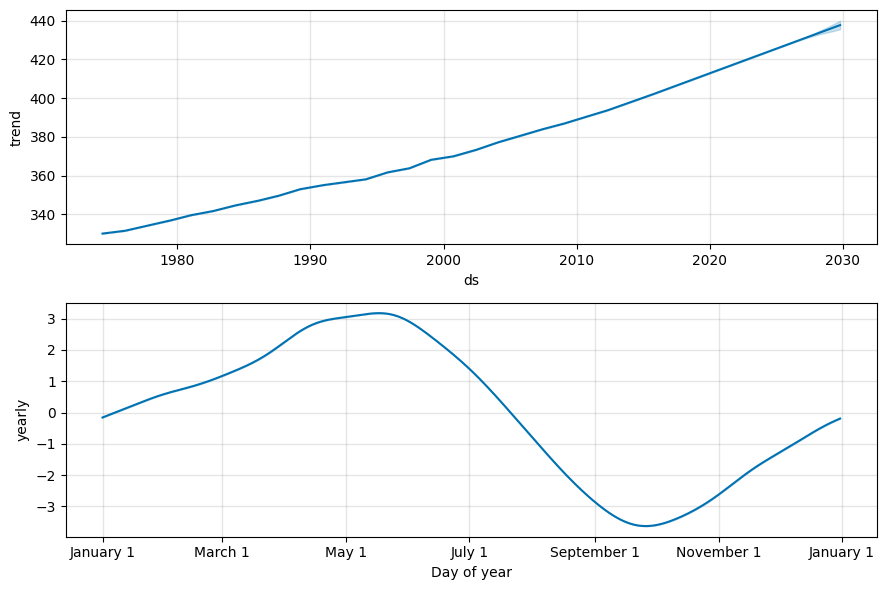

In [116]:
model, pred = build_model(train_co2, val_co2, calculate_metrics=False, pred_len=209, freq='W')
final_model(model, pred, 'Co2', title="Predict average Co2 for next 4 years")

---
## Hourly AEP

In [106]:
aep = pd.read_csv('../data/hourly_aep.csv')
aep['data_ind'] = aep['Date']
aep = aep.set_index('data_ind')
aep.index = pd.to_datetime(aep.index)

train_df = aep.loc[aep.index < '2015-10-27 06:00:00']
val_df = aep.loc[aep.index >= '2015-10-27 06:00:00']

train = train_df[['AEP_MW']].reset_index()
train['unique_id'] = 'mw'
train.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
train_aep = train[['unique_id', 'ds', 'y']]

val = val_df[['AEP_MW']].reset_index()
val['unique_id'] = 'mw'
val.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
val_aep = val[['unique_id', 'ds', 'y']]

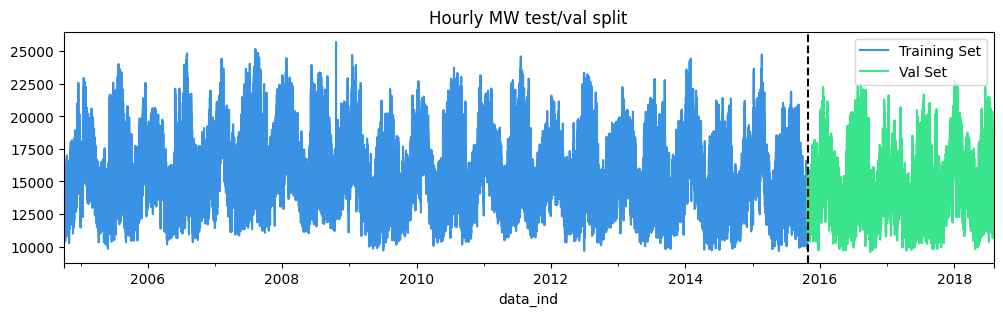

In [107]:
y_train = train_df['AEP_MW']
y_val = val_df['AEP_MW']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Hourly MW test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('2015-10-27 06:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

23:26:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:18 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1409.45,
 RMSE = 1809.38


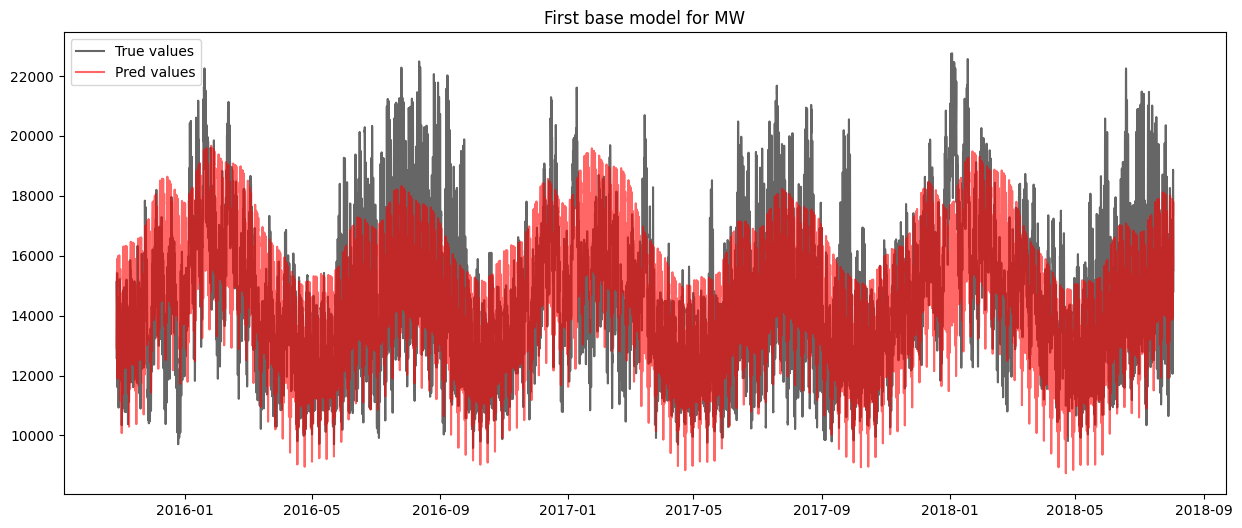

In [108]:
pred = build_model(train_aep, val_aep)
pred_plot(val_aep['ds'], val_aep['y'], pred, title="First base model for MW")

23:27:23 - cmdstanpy - INFO - Chain [1] start processing
23:27:53 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1398.01,
 RMSE = 1791.25


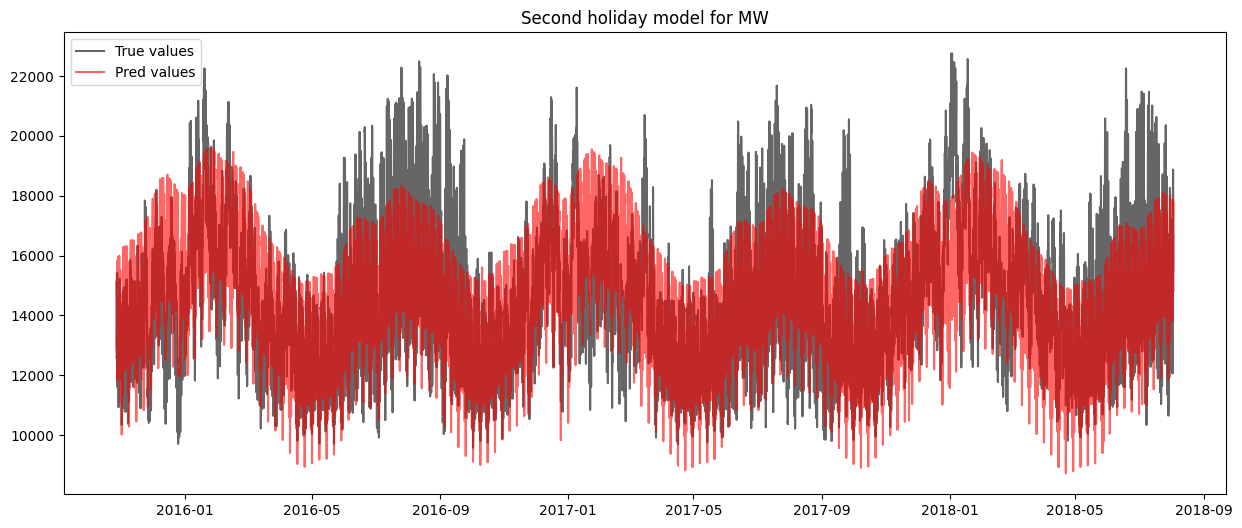

In [109]:
pred = build_model(train_aep, val_aep, holiday=True)
pred_plot(val_aep['ds'], val_aep['y'], pred, title="Second holiday model for MW")

23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1392.04,
 RMSE = 1785.20


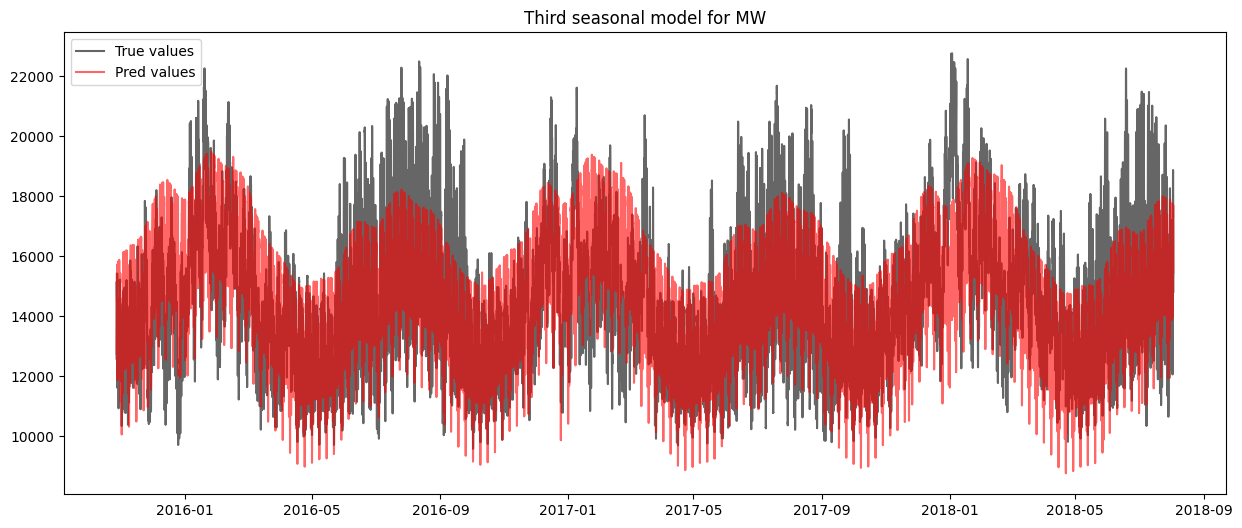

In [110]:
pred = build_model(train_aep, val_aep, holiday=True, season=True, s_name='hourly')
pred_plot(val_aep['ds'], val_aep['y'], pred, title="Third seasonal model for MW")

First model is worth, second and third almost the same. We will take third one.

23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing


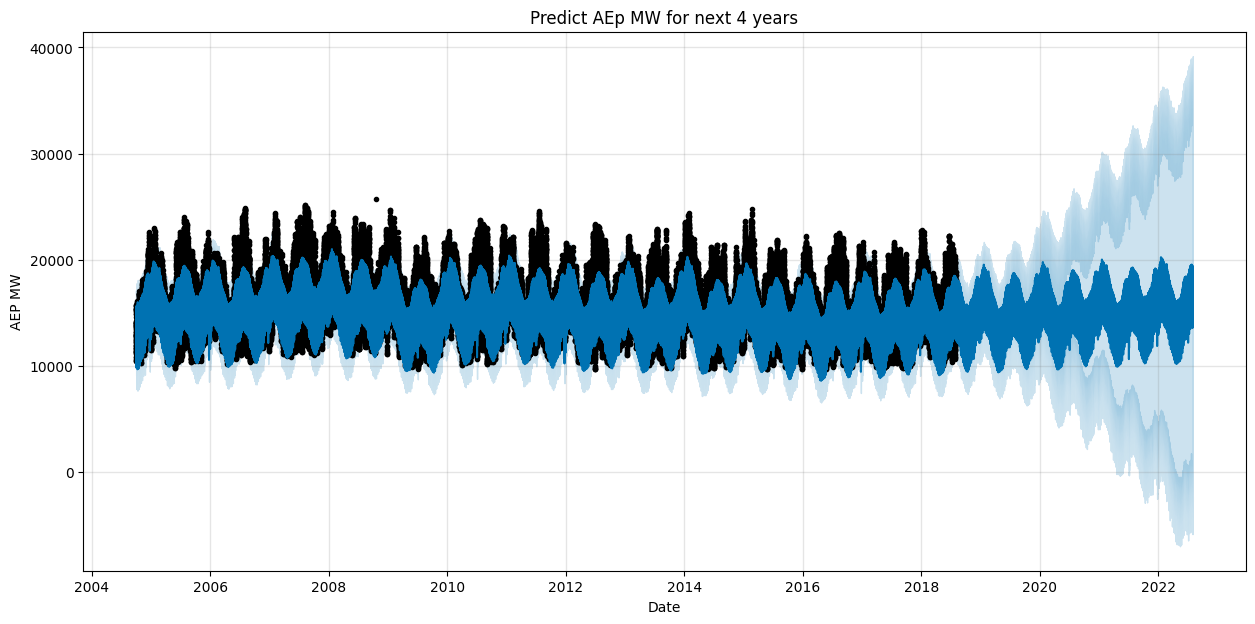

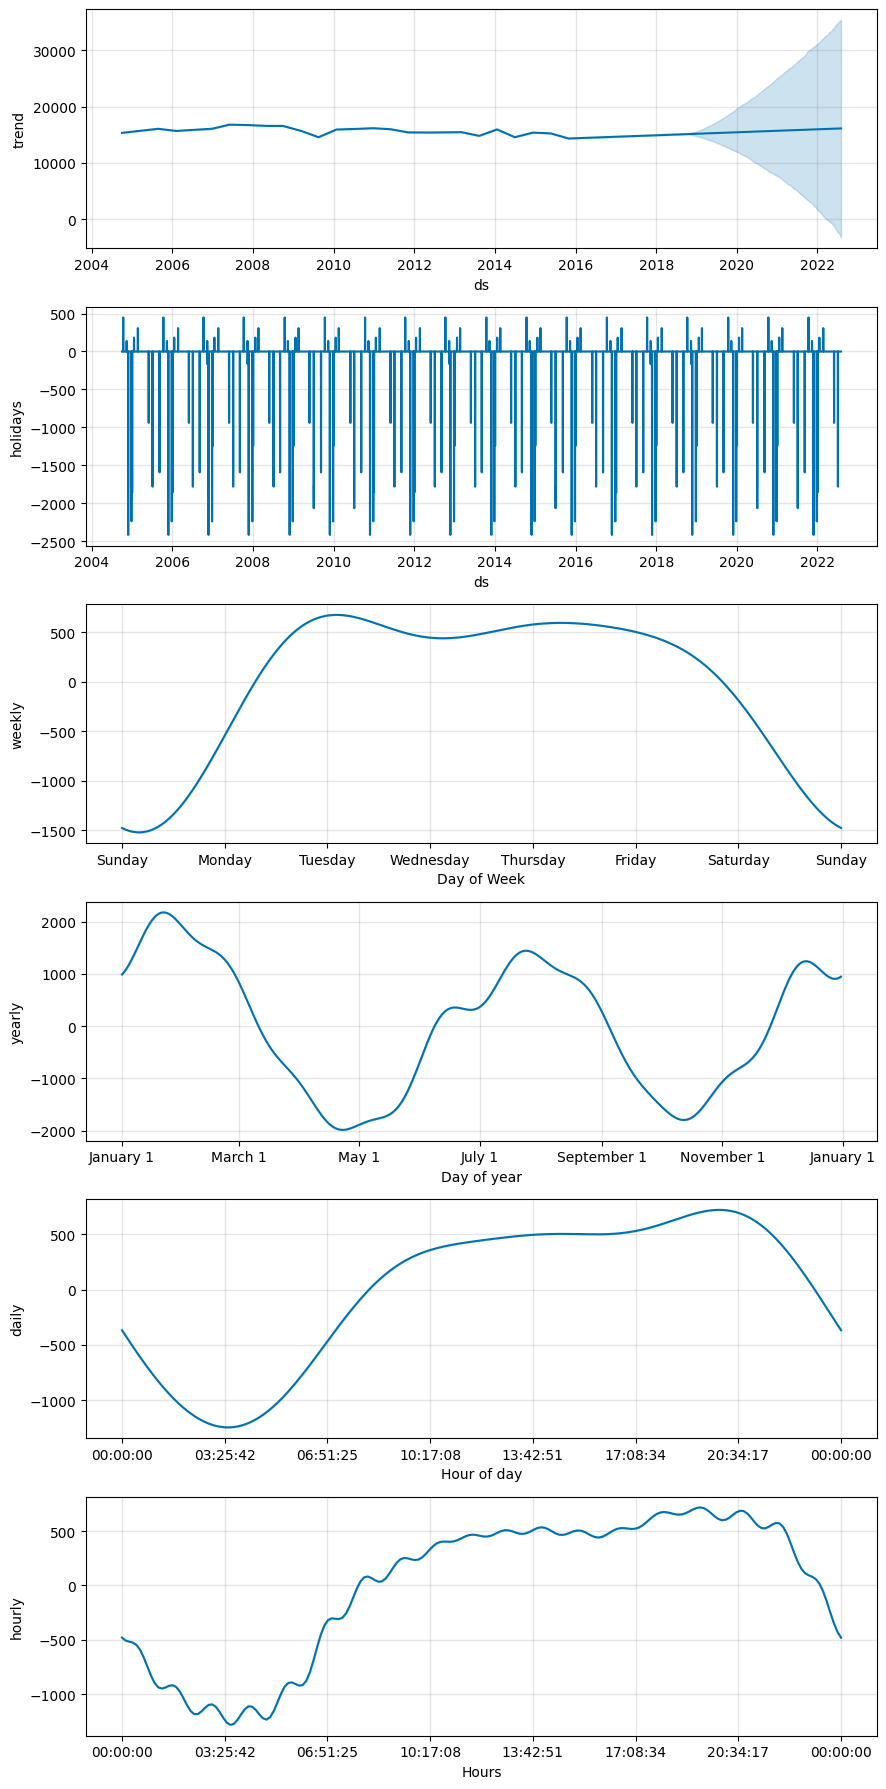

In [115]:
model, pred = build_model(train_aep, val_aep, holiday=True, season=True,
                          s_name='hourly', calculate_metrics=False, pred_len=35041, freq='h')
final_model(model, pred, 'AEP MW', title="Predict AEp MW for next 4 years")

---